# Customer Segmentation

**Problem:**
- In this project, we delve deep into the thriving sector of online retail by analyzing a transactional dataset from a UK-based retailer, available at the UCI Machine Learning Repository. This dataset documents all transactions between 2010 and 2011. Our primary objective is to amplify the efficiency of marketing strategies and boost sales through customer segmentation. We aim to transform the transactional data into a customer-centric dataset by creating new features that will facilitate the segmentation of customers into distinct groups using the K-means clustering algorithm. This segmentation will allow us to understand the distinct profiles and preferences of different customer groups. 

**Objectives:**
- Data Cleaning & Transformation: Clean the dataset by handling missing values, duplicates, and outliers, preparing it for effective clustering.
- Feature Engineering: Develop new features based on the transactional data to create a customer-centric dataset, setting the foundation for customer segmentation.
- Data Preprocessing: Undertake feature scaling and dimensionality reduction to streamline the data, enhancing the efficiency of the clustering process.
- Customer Segmentation using K-Means Clustering: Segment customers into distinct groups using K-means, facilitating targeted marketing and personalized strategies.
- Cluster Analysis & Evaluation: Analyze and profile each cluster to develop targeted marketing strategies and assess the quality of the clusters formed

**Importing Necessary Libraries**

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import plotly.express as px
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


**Loading the Dataset**

In [2]:
df = pd.read_excel('Online Retail.xlsx')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


**Dataset Overview**

In [3]:
def data_overview(df):
    print('Shape of Dataset'.center(120,'-'))
    print(f'number of Rows {df.shape[0]}')
    print(f'number of Columns {df.shape[1]}')
    print('Data'.center(120,'-'))
    print(df)
    print('Data Types'.center(120,'-'))
    print(df.dtypes.value_counts())
    print('Missing Values'.center(120,'-'))
    print(df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending = False))
    print('Duplicated Values'.center(120,'-'))
    print(df.duplicated().sum())
    print(" Statistics of Data ".center(120,'-'))
    print(df.describe(include="all"))
    print("Data Info".center(120,'-'))
    print(df.info())
    
    
data_overview(df)

----------------------------------------------------Shape of Dataset----------------------------------------------------
number of Rows 541909
number of Columns 8
----------------------------------------------------------Data----------------------------------------------------------
       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23

**Observations :**
- The Dataset has Rows: 541909 and Columns:8 
- The Dataset has 4 types of columns: strings(4), integer(1), float(2),datetime(1)
- The Dataset has Missing values in Customer ID (135080) and Description (1454)
- The Dataset has duplicates
- Invoice starts with the 'c' needs to be cleaned as it is cancelled transaction
- Also check for negative value and outliers in Quantity and Price

# Data Wrangling

In [4]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
df =df.dropna()
df.shape

(406829, 8)

In [6]:
#Remove Dublicated rows
df= df.drop_duplicates(keep="first")
df['Quantity'] = df['Quantity'].abs()

In [7]:
# converting negative values into postive values
df['UnitPrice'] = df['UnitPrice'].abs()

In [8]:
df['UnitPrice'].min()

0.0

In [9]:
df = df[df['UnitPrice'] > 0]


In [10]:
# Removing cancelled products from invoice
df  = df[~df.InvoiceNo.str.contains('C',na=False)]

In [11]:
# removing outliers from Quantity , Unitprice
for col in ['Quantity','UnitPrice']:
    low, high = df[col].quantile([0.05,0.95])
    df = df[df[col].between(low, high)]

In [12]:
# conert dtype [CustomerID] to str 
df['CustomerID'] = df['CustomerID'].astype(str)


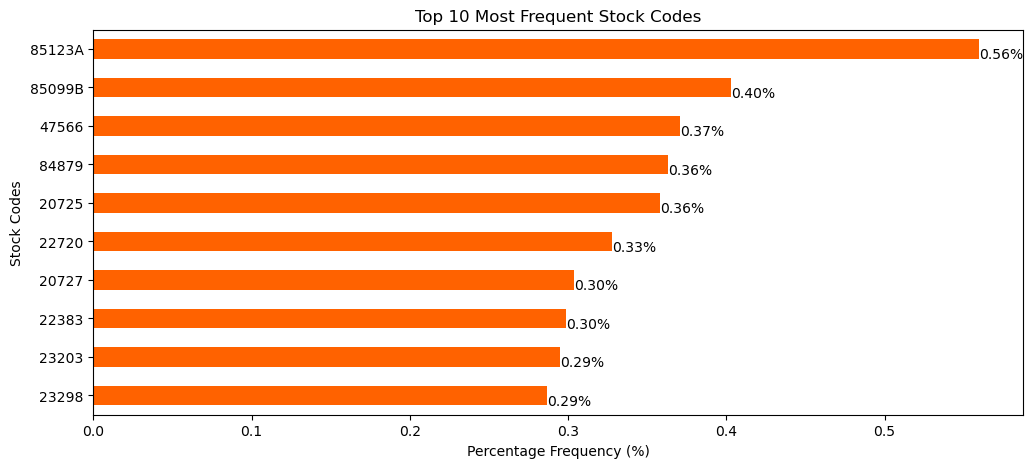

In [13]:
# Finding the top 10 most frequent stock codes
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100

# Plotting the top 10 most frequent stock codes
plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='#ff6200')

# Adding the percentage frequency on the bars
for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

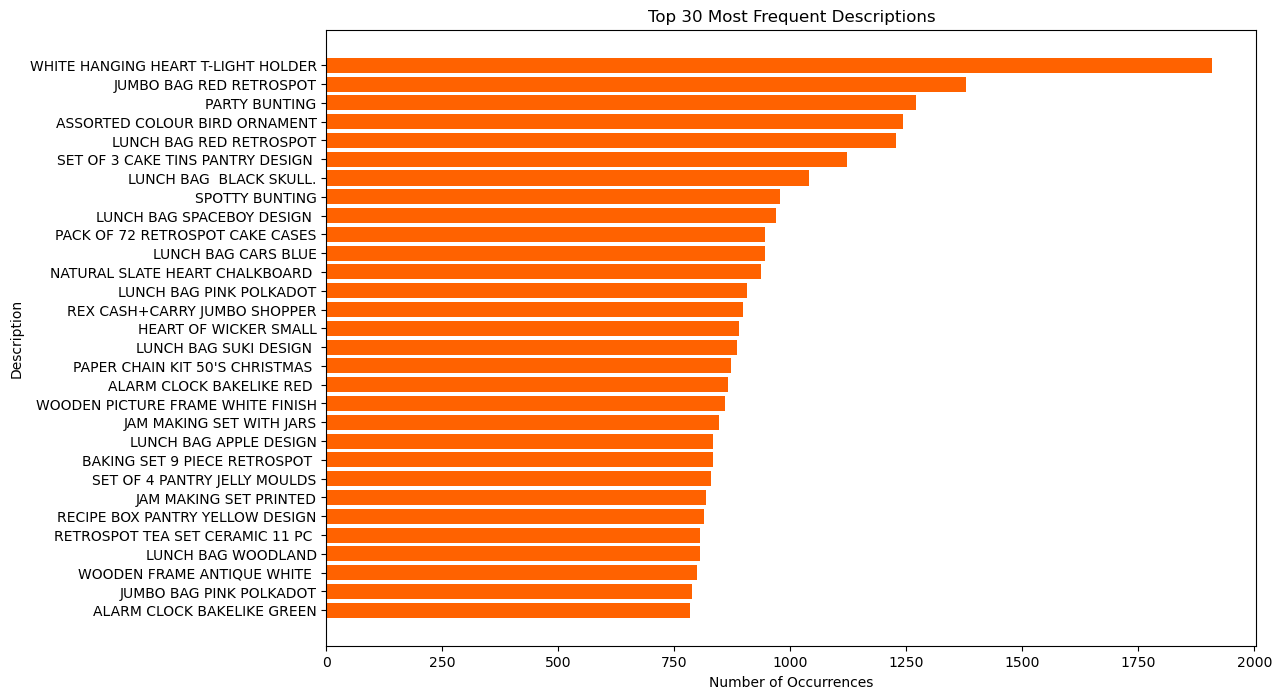

In [15]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['Description'].value_counts()

# Get the top 30 descriptions
top_30_descriptions = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

# EDA : Feature Engineering

RFM is a method used for analyzing customer value and segmenting the customer base. It is an acronym that stands for:

- **Recency (R)**: This metric indicates how recently a customer has made a purchase. A lower recency value means the customer has purchased more recently, indicating higher engagement with the brand.
- **Frequency (F)**: This metric signifies how often a customer makes a purchase within a certain period. A higher frequency value indicates a customer who interacts with the business more often, suggesting higher loyalty or satisfaction.
- **Monetary (M)**: This metric represents the total amount of money a customer has spent over a certain period. Customers who have a higher monetary value have contributed more to the business, indicating their potential high lifetime value.

In [16]:
df["Total_spend"] = df["Quantity"] * df["UnitPrice"]


In [17]:
print("Max date :",df["InvoiceDate"].max())
print("Min date :",df["InvoiceDate"].min())

Max date : 2011-12-09 12:50:00
Min date : 2010-12-01 08:26:00


In [46]:
Latest_Date = dt.datetime(2011,12,10)

customer_data = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (Latest_Date - x.max()).days, 
                                                 'InvoiceNo': lambda x: x.nunique(), 
                                                 "Total_spend": lambda x: x.sum(),
                                                'Quantity':lambda x :x.sum(),
                                                'StockCode':lambda x: x.nunique(),
                                                'Description': lambda x:x.mode()[0]
                                   })
                                
customer_data['InvoiceDate'] = customer_data['InvoiceDate'].astype(int)

#Renaming column names to Recency, Frequency and Monetary
customer_data.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency', 
                         'Total_spend': 'Monetary' ,
                        'Quantity':'Total_Products_Purchased',
                       'StockCode' :'Unique_Products_Purchased',
                        'Description':'Popular_products'
                   }, inplace=True)

customer_data.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,Total_Products_Purchased,Unique_Products_Purchased,Popular_products
0,12347.0,2,7,3726.63,2091,98,AIRLINE BAG VINTAGE JET SET BROWN
1,12348.0,248,3,90.20,140,6,60 CAKE CASES VINTAGE CHRISTMAS
2,12349.0,18,1,1287.15,619,66,20 DOLLY PEGS RETROSPOT
3,12350.0,310,1,294.40,196,16,4 TRADITIONAL SPINNING TOPS
4,12352.0,36,7,1232.44,512,53,LIGHT GARLAND BUTTERFILES PINK


In [65]:
data = customer_data.drop(['Popular_products'],axis = 1)

In [69]:
# Create a DataFrame containing the selected attributes
attributes = ['Monetary', 'Frequency', 'Recency','Total_Products_Purchased','Unique_Products_Purchased']
data = data[attributes]

# Create a box plot with Plotly
fig = px.box(data, y=attributes, labels={'variable': 'Attributes', 'value': 'Range'},
             title="Outliers Variable Distribution")
fig.update_layout(
    xaxis=dict(title="Attributes"),
    yaxis=dict(title="Range"),
    showlegend=False,
    boxmode='group',  # Display box plots side by side
    width=800, height=600
)
fig.show()

In [68]:
for col in data.columns:
    Q1 = data[col].quantile(0.05)
    Q3 = data[col].quantile(0.95)
    IQR = Q3 - Q1
    data = data[(data[col] >= Q1 - 1.5*IQR) & (data[col]<= Q3 + 1.5*IQR)]



**Recency:** 
  - This feature represents the total number of transactions made by a customer. It helps in understanding the engagement level of a customer with the retailer.

**Total Products Purchased:** 
  - This feature indicates the total number of products (sum of quantities) purchased by a customer across all transactions. It gives an insight into the customer's buying behavior in terms of the volume of products purchased.

**Monetary:** This feature represents the total amount of money spent by each customer. It is calculated as the sum of the product of UnitPrice and Quantity for all transactions made by a customer. This feature is crucial as it helps in identifying the total revenue generated by each customer, which is a direct indicator of a customer's value to the business.



**Unique Products Purchased:**

This feature represents the number of distinct products bought by a customer. A higher value indicates that the customer has a diverse taste or preference, buying a wide range of products, while a lower value might indicate a focused or specific preference. Understanding the diversity in product purchases can help in segmenting customers based on their buying diversity

<Figure size 1500x800 with 0 Axes>

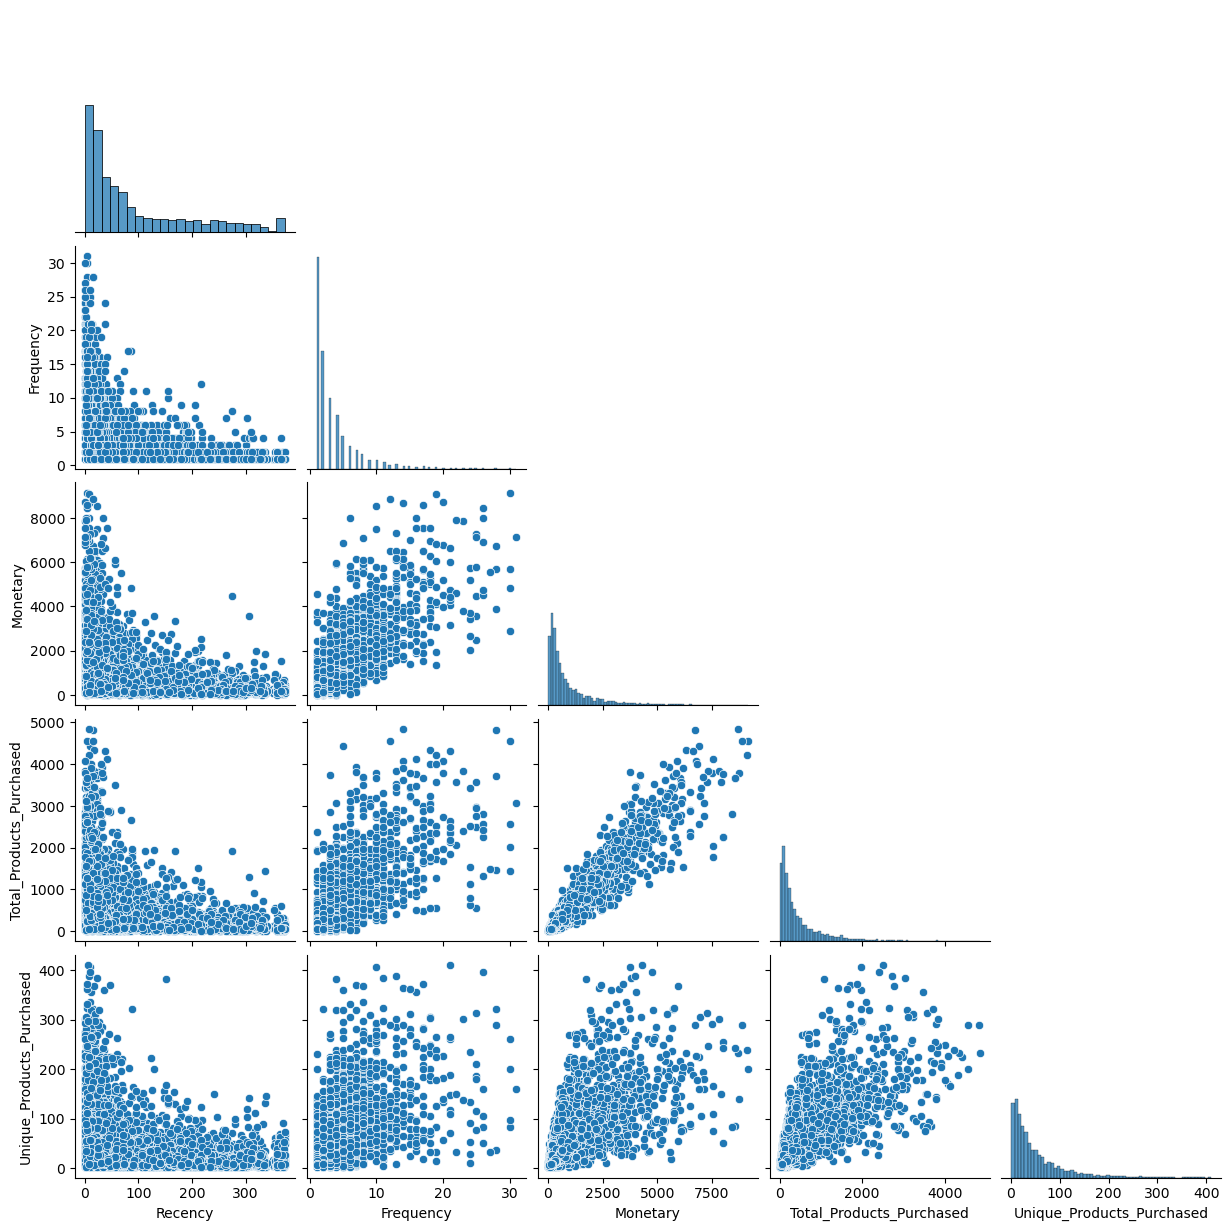

In [70]:
plt.figure(figsize=(15,8))
sns.pairplot(data, corner=True)
plt.show()

In [71]:
scaler = StandardScaler()

# fit_transform
data_scaled = scaler.fit_transform(data)


In [72]:
n_clusters = range(2,12)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.

for n in n_clusters:
    model = KMeans(n, n_init = 100,init='k-means++',random_state=0)
    model.fit(data_scaled)
    inertia_errors.append(model.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled, model.labels_))
    

print("Inertia:", inertia_errors[:3])
print()
print("Silhouette Scores:", silhouette_scores[:3])




Inertia: [11128.732952618011, 7924.505681623625, 5761.738868767379]

Silhouette Scores: [0.5526002415003723, 0.4146945411172034, 0.42766142965535825]


In [73]:
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(x = n_clusters, y = inertia_errors, 
                 title = 'K-Means Model: Inertia vs Number of Clusters'
)
fig.update_layout(xaxis_title ='n_clusters', yaxis_title = 'Inertia')
fig.show()

In [74]:
# Create a line plot of `silhouette_scores` vs `n_clusters`
fig = px.line(x = n_clusters, y = silhouette_scores, 
                 title = 'K-Means Model: silhouette_scores vs Number of Clusters')
fig.update_layout(xaxis_title ='n_clusters', yaxis_title = 'silhouette_scores')
fig.show()

In [76]:
from sklearn.pipeline import make_pipeline
final_model = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters= 3, n_init = 100,init='k-means++',random_state=0)
)
final_model.fit(data)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, n_init=100, random_state=0))])

In [77]:
labels = final_model.named_steps['kmeans'].labels_
labels

array([1, 0, 2, ..., 2, 1, 2])

### **Conclusion:**
- Based on the silhouette score, you could choose  3 clusters,

- However, considering the results from both methods and the fact that the elbow method indicates a clear point at 3 clusters, it may be a good idea to choose 3 clusters as the number of clusters for your clustering analysis.

- Ultimately, the choice between 3 and 5 clusters depends on your specific problem, the insights you want to gain, and your preference for having a more detailed or simplified grouping of your data.

In [78]:
data['cluster_id'] = labels

In [55]:
data

,Recency,Frequency,Monetary,Total_Products_Purchased,Unique_Products_Purchased,cluster_id
CustomerID,,,,,,
12347.0,2,7,3726.63,2091,98,2
12348.0,248,3,90.20,140,6,0
12349.0,18,1,1287.15,619,66,0
12350.0,310,1,294.40,196,16,0
12352.0,36,7,1232.44,512,53,0
...,...,...,...,...,...,...
18280.0,277,1,160.70,43,9,0
18281.0,180,1,46.92,52,5,0
18282.0,7,2,113.13,51,8,0


In [79]:
xgb = data.groupby('cluster_id').mean()
xgb


,Recency,Frequency,Monetary,Total_Products_Purchased,Unique_Products_Purchased
cluster_id,,,,,
0,245.456459,1.427751,302.796833,156.889952,20.725359
1,24.156729,10.306644,3391.531261,1804.524702,148.671210
2,46.014291,2.884478,693.332017,374.659786,42.091306


In [80]:
# Create side-by-side bar chart of `xgb`
fig = px.bar(xgb, barmode= 'group',title = 'Mean  by Cluster')

fig.update_layout(xaxis_title = 'Cluster', yaxis_title = 'Value [$]')
fig.show()

In [81]:
data['Popular_products'] = customer_data['Popular_products']

<Axes: title={'center': 'Top 10 popular products for cluster 0'}, xlabel='count', ylabel='Popular_products'>

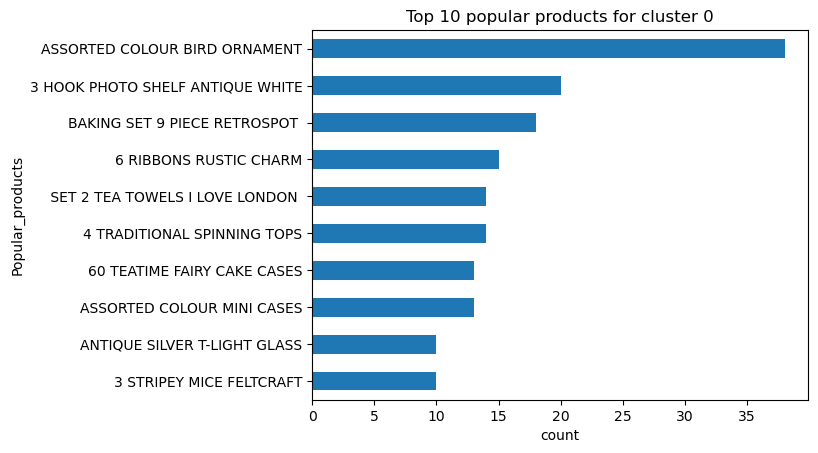

In [82]:
popular_products_by_cluster0 = data[data['cluster_id'] == 0]
class0 = pd.DataFrame(popular_products_by_cluster0)

# Group by 'cluster_id' and count the occurrences of each product
product_counts = class0['Popular_products'].groupby(class0['cluster_id']).value_counts()
product_counts = product_counts.droplevel(level = 0)
product_counts.sort_values().tail(10).plot(kind = 'barh',xlabel = 'count', ylabel='Popular_products',title ='Top 10 popular products for cluster 0')



<Axes: title={'center': 'Top 10 popular products for cluster 1'}, xlabel='count', ylabel='Popular_products'>

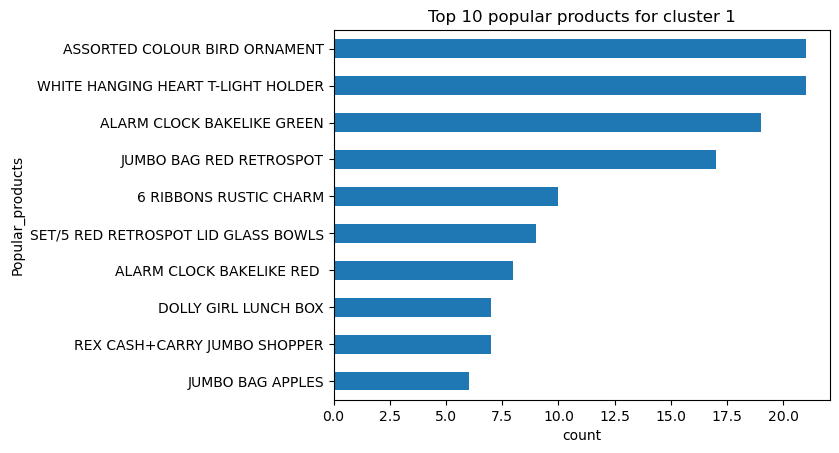

In [83]:
popular_products_by_cluster1 = data[data['cluster_id'] == 1]
class1 = pd.DataFrame(popular_products_by_cluster1)
popular_products_by_cluster1
# Group by 'cluster_id' and count the occurrences of each product
product_counts = class1['Popular_products'].groupby(class1['cluster_id']).value_counts()
product_counts = product_counts.droplevel(level = 0)
product_counts.sort_values().tail(10).plot(kind = 'barh',xlabel = 'count', ylabel='Popular_products',title ='Top 10 popular products for cluster 1')


<Axes: title={'center': 'Top 10 popular products for cluster 2'}, xlabel='count', ylabel='Popular_products'>

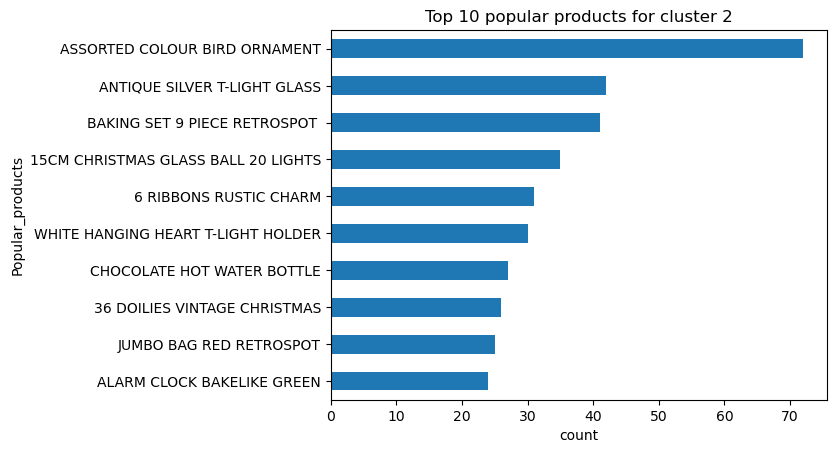

In [84]:
popular_products_by_cluster2 = data[data['cluster_id'] == 2]
class2 = pd.DataFrame(popular_products_by_cluster2)

# Group by 'cluster_id' and count the occurrences of each product
product_counts = class2['Popular_products'].groupby(class2['cluster_id']).value_counts()
product_counts = product_counts.droplevel(level = 0)
product_counts.sort_values().tail(10).plot(kind = 'barh',xlabel = 'count', ylabel='Popular_products',title ='Top 10 popular products for cluster 2')


In [88]:
pca = PCA(n_components=2, random_state=42)

# Transform `X`
data = data.drop('Popular_products',axis =1)
X_t = pca.fit_transform(data)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns= ['PC1','PC2'])

print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (4151, 2)


,PC1,PC2
0,3164.948254,-122.319332
1,-967.264893,-64.265322
2,322.403741,54.650561
3,-761.677163,-18.303133
4,223.792814,125.343116


In [89]:
# Create scatter plot of `PC2` vs `PC1`
fig = px.scatter(data_frame=X_pca, x = 'PC1', y = 'PC2', color= labels.astype(str), title ='PCA Representation of Clusters' )

fig.update_layout(xaxis_title = 'pc1', yaxis_title = 'pc2')
fig.show()